# Linear Models and Regularization Methods

In this lab we implement many of the techniques discussed in this chapter.
We import some of our libraries at this top
level. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

We again collect the new imports
needed for this lab. Readers will also have to have installed `l0bnb` using `pip install l0bnb`.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Subset Selection Methods
Here we implement methods that reduce the number of parameters in a
model by restricting the model to a subset of the input variables.

### Forward Selection
 
We will  apply the forward-selection approach to the  `Hitters` 
data.  We wish to predict a baseball player’s `Salary` on the
basis of various statistics associated with performance in the
previous year.

First of all, we note that the `Salary` variable is missing for
some of the players.  The `np.isnan()`  function can be used to
identify the missing observations. It returns an array
of the same shape as the input vector, with a `True` for any elements that
are missing, and a `False` for non-missing elements.  The
`sum()`  method can then be used to count all of the
missing elements.

In [4]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

 We see that `Salary` is missing for 59 players. The
`dropna()`  method of data frames removes all of the rows that have missing
values in any variable (by default --- see  `Hitters.dropna?`).

In [5]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

In [6]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We first choose the best model using forward selection based on $C_p$ (\ref{Ch6:eq:cp}). This score
is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use
it as a scorer. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [7]:
def nCp(sigma2, estimator, X, Y):
    """
    Calculate the Negative Cp statistic.
    
    Parameters:
    sigma2 (float): The variance estimate of the error term.
    estimator (object): A fitted model with a 'predict' method.
    X (array-like): The feature matrix.
    Y (array-like): The target vector.

    Returns:
    float: The Negative Cp statistic value.
    """
    
    # Get the number of observations (n) and the number of features (p) from X
    n, p = X.shape
    
    # Use the estimator to predict the target values based on the feature matrix X
    Yhat = estimator.predict(X)
    
    # Calculate the residual sum of squares (RSS), which is the sum of squared differences between the actual and predicted values
    RSS = np.sum((Y - Yhat)**2)
    
    # Calculate and return the Negative Cp statistic, which is given by the formula:
    # -(RSS + 2 * p * sigma2) / n
    return -(RSS + 2 * p * sigma2) / n

We need to estimate the residual variance $\sigma^2$, which is the first argument in our scoring function above.
We will fit the biggest model, using all the variables, and estimate $\sigma^2$ based on its MSE.

In [8]:
# Fit a feature transformation model to the dataset, excluding the 'Salary' column
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)

# Extract the target variable 'Salary' from the dataset and convert it to a NumPy array
Y = np.array(Hitters['Salary'])

# Transform the dataset using the fitted transformation model to create feature matrix X
X = design.transform(Hitters)

# Fit an Ordinary Least Squares (OLS) model to the transformed features (X) and target (Y)
sigma2 = OLS(Y, X).fit().scale

The function `sklearn_selected()` expects a scorer with just three arguments --- the last three in the definition of `nCp()` above. We use the function `partial()` first seen in Section~\ref{Ch5-resample-lab:the-bootstrap} to freeze the first argument with our estimate of $\sigma^2$.

In [9]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.


Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.

In [10]:
# Initialize the stepwise regression strategy
strategy = Stepwise.first_peak(  
    design,                      # Feature transformation model used for stepwise regression
    direction='forward',         # Specify forward selection direction for adding features
    max_terms=len(design.terms)  # Set the maximum number of terms to the number of features in the design
)

We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.

In [11]:
Hitters_MSE = sklearn_selected(  # Create an instance of the sklearn_selected class using OLS and the stepwise strategy
    OLS,                         # Ordinary Least Squares model
    strategy                     # Stepwise selection strategy to be used
)

Hitters_MSE.fit(  # Fit the sklearn_selected model to the data
    Hitters,      # Input feature matrix
    Y             # Target variable
)

Hitters_MSE.selected_state_  # Retrieve the state of the selected features from the fitted model

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [12]:
Hitters_Cp = sklearn_selected(  # Create an instance of the sklearn_selected class using OLS, stepwise strategy, and a custom scoring function
    OLS,                        # Ordinary Least Squares model
    strategy,                   # Stepwise selection strategy to be used
    scoring=neg_Cp              # Custom scoring function for evaluating model performance
)

Hitters_Cp.fit(  # Fit the sklearn_selected model to the data
    Hitters,     # Input feature matrix
    Y            # Target variable
)

Hitters_Cp.selected_state_  # Retrieve the state of the selected features from the fitted model

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### Choosing Among Models Using the Validation Set Approach and Cross-Validation
 
As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` 
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [13]:
strategy = Stepwise.fixed_steps(
    design,               # The design matrix for the regression model, which includes all features
    len(design.terms),    # The total number of features to consider in the selection process
    direction='forward'   # Direction of feature selection: 'forward' means adding features one by one
)

full_path = sklearn_selection_path(
    OLS,                   # The Ordinary Least Squares model to be used for regression
    strategy               # The stepwise selection strategy defined above
)

We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [14]:
full_path.fit(Hitters, Y)             # Fit the model selection path to the data using the Hitters dataset and target variable Y
Yhat_in = full_path.predict(Hitters)  # Predict target values using the fitted model and the Hitters dataset
Yhat_in.shape                         # Get the shape of the predicted values array

(263, 20)

This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

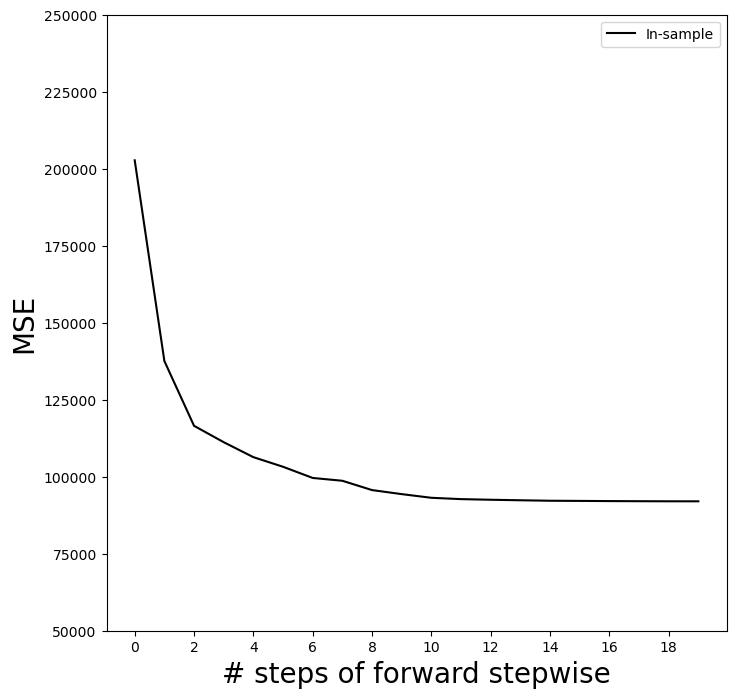

In [15]:
mse_fig, ax = subplots(figsize=(8, 8))              # Create a figure and axis for plotting with a specified figure size of 8x8 inches
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)  # Compute the mean squared error (MSE) for each step of the forward stepwise selection
n_steps = insample_mse.shape[0]                     # Determine the number of steps in the forward stepwise process
ax.plot(
    np.arange(n_steps),  # X-axis: range of steps
    insample_mse,        # Y-axis: MSE values
    'k',                 # Color: black
    label='In-sample'    # Label for the plot
)
ax.set_ylabel(
    'MSE',               # Y-axis label
    fontsize=20          # Font size for the Y-axis label
)
ax.set_xlabel(
    '# steps of forward stepwise',  # X-axis label
    fontsize=20                     # Font size for the X-axis label
)
ax.set_xticks(np.arange(n_steps)[::2])  # Set X-axis ticks to show every other step
ax.legend()                             # Display the legend for the plot
ax.set_ylim([50000, 250000]);           # Set the Y-axis limits to range from 50,000 to 250,000

Notice the expression `None` in `Y[:,None]` above.
This adds an axis (dimension) to the one-dimensional array `Y`,
which allows it to be recycled when subtracted from the two-dimensional `Yhat_in`.

We are now ready to use cross-validation to estimate test error along
the model path. We must use *only the training observations* to perform all aspects of model-fitting --- including
variable selection.  Therefore, the determination of which model of a
given size is best must be made using \emph{only the training
  observations} in each training fold. This point is subtle but important.  If the full data
set is used to select the best subset at each step, then the validation
set errors and cross-validation errors that we obtain will not be
accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold cross-validation.

In [16]:
K = 5                # Number of folds for cross-validation

kfold = skm.KFold(
    K,               # Number of splits (folds)
    random_state=0,  # Seed for random number generator to ensure reproducibility
    shuffle=True     # Whether to shuffle the data before splitting into batches
)
Yhat_cv = skm.cross_val_predict(
    full_path,       # Model selection path to be evaluated
    Hitters,         # Input feature matrix
    Y,               # Target variable
    cv=kfold         # Cross-validation strategy
)
Yhat_cv.shape        # Get the shape of the cross-validated predictions array

(263, 20)

`skm.cross_val_predict()`
The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on a training fold that did not include that row.

At each model along the path, we compute the MSE in each of the cross-validation folds.
These we will average to get the  mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean. {The estimate is crude because the five error estimates  are based on overlapping training sets, and hence are not independent.}
Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of `kfold`. Because
we  fixed the random state above, whenever we split any array with the same
number of rows as $Y$ we recover the same training and test indices, though we simply
ignore the training indices below.

In [17]:
cv_mse = []  # Initialize an empty list to store cross-validation MSE values

for train_idx, test_idx in kfold.split(Y):               # Iterate over the splits created by KFold
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2  # Compute squared errors for the test set
    cv_mse.append(errors.mean(0))                        # Calculate mean squared error for each test set and append to the list

cv_mse = np.array(cv_mse).T  # Convert list of MSE values to a NumPy array and transpose it
cv_mse.shape                 # Get the shape of the cross-validation MSE array

(20, 5)

We now add the cross-validation error estimates to our MSE plot.
We include the mean error across the five folds, and the estimate of the standard error of the mean. 

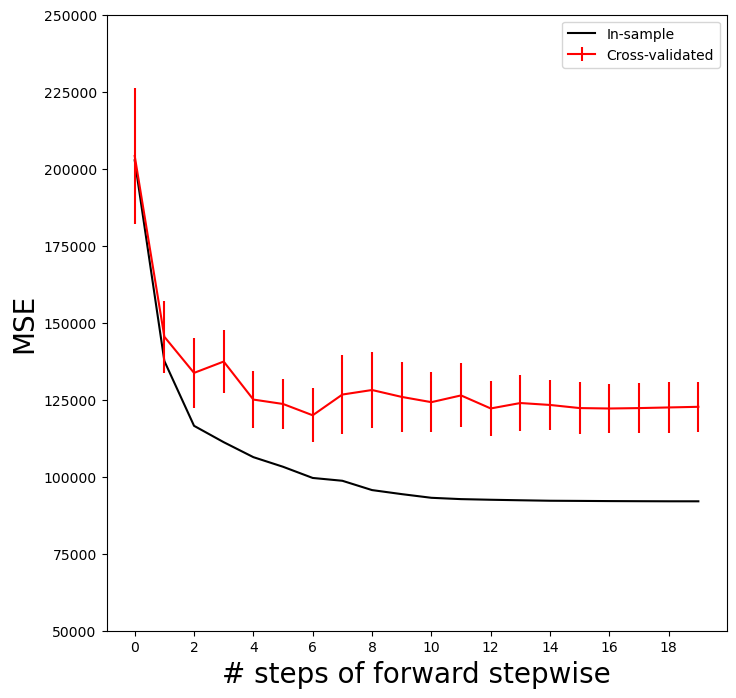

In [18]:
ax.errorbar(
    np.arange(n_steps),          # X-axis values: number of steps in forward stepwise
    cv_mse.mean(1),              # Mean cross-validated MSE values for each step
    cv_mse.std(1) / np.sqrt(K),  # Standard error of the mean for cross-validated MSE values
    label='Cross-validated',     # Label for the error bar plot
    c='r'                        # Color of the error bars: red
) 
ax.set_ylim([50000, 250000])  # Set the y-axis limits for the plot
ax.legend()                   # Display the legend for the plot
mse_fig                       # Display the figure with the error bars

To repeat the above using the validation set approach, we simply change our
`cv` argument to a validation set: one random split of the data into a test and training. We choose a test size
of 20%, similar to the size of each test set in 5-fold cross-validation.`skm.ShuffleSplit()`

In [19]:
validation = skm.ShuffleSplit(  # Create a ShuffleSplit object for validation
    n_splits=1,                 # Number of re-shuffling and splitting iterations
    test_size=0.2,              # Proportion of the data to include in the test split
    random_state=0              # Seed for the random number generator
)

# Iterate over the train-test splits generated by ShuffleSplit
for train_idx, test_idx in validation.split(Y):
    
    # Fit the model on the training data
    full_path.fit(Hitters.iloc[train_idx],  # Training feature matrix
                  Y[train_idx])             # Training target variable
    
    # Predict on the validation data
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])  # Predicted values on the test set
    
    # Calculate the mean squared error (MSE) for the validation predictions
    errors = (Yhat_val - Y[test_idx, None])**2    # Squared errors between predictions and actual values
    validation_mse = errors.mean(0)               # Mean MSE across all features

 As for the in-sample MSE case, the validation set approach does not provide standard errors.

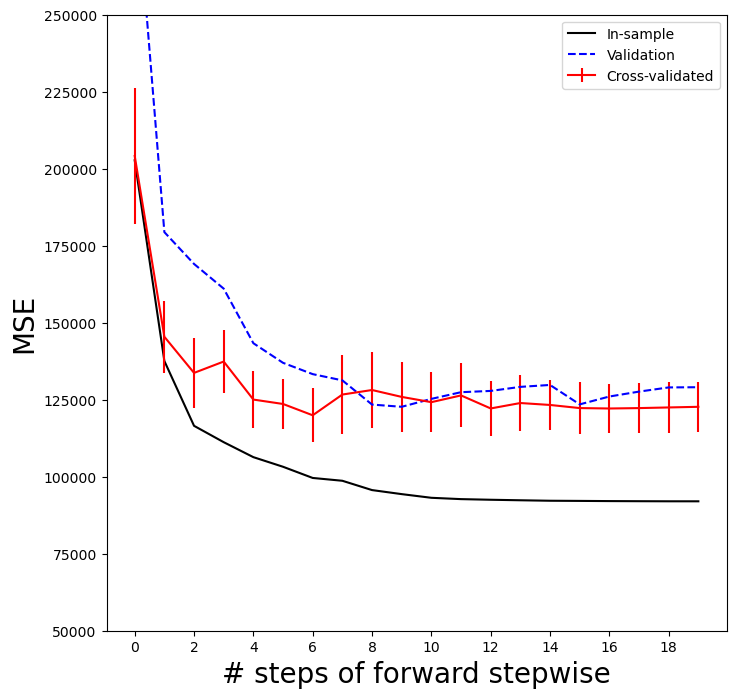

In [20]:
ax.plot(np.arange(n_steps),   # X-axis: number of steps
        validation_mse,       # Y-axis: validation mean squared error
        'b--',                # Line style: blue dashed line
        label='Validation')   # Label for the validation curve in the legend

# Set x-axis ticks to every other step
ax.set_xticks(np.arange(n_steps)[::2])

# Set y-axis limits for the plot
ax.set_ylim([50000, 250000])

# Add a legend to the plot
ax.legend()

# Display the figure
mse_fig

### Best Subset Selection
Forward stepwise is a *greedy* selection procedure; at each step it augments the current set by including one additional variable.  We now apply best subset selection  to the  `Hitters` 
data, which for every subset size, searches for the best set of predictors.  

We will use a package called `l0bnb` to perform
best subset selection.
Instead of constraining the subset to be a given size,
this package produces a path of solutions using the subset size as a
penalty rather than a constraint. Although the distinction is subtle, the difference comes when we cross-validate. 


In [21]:
D = design.fit_transform(Hitters)  # Apply the design matrix transformation to the Hitters dataset

D = D.drop('intercept', axis=1)    # Drop the 'intercept' column from the transformed design matrix

X = np.asarray(D)                  # Convert the DataFrame to a NumPy array

Here we excluded the first column corresponding to the intercept, as
`l0bnb` will fit the intercept separately. We can find a path using the `fit_path()` function.

In [22]:
path = fit_path(
    X,                        # Input feature matrix
    Y,                        # Target variable
    max_nonzeros=X.shape[1]   # Maximum number of non-zero coefficients to consider in the path
)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


The function `fit_path()` returns a list whose values include the fitted coefficients as `B`, an intercept as `B0`, as well as a few other attributes related to the particular path algorithm used. Such details are beyond the scope of this book.

In [23]:
path[3]  # Accesses the fourth element in the path

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.01141624802745019,
 'M': 0.5829861733382014,
 'Time_exceeded': False}

In the example above, we see that at the fourth step in the path, we have two nonzero coefficients in `'B'`, corresponding to the value $0.114$ for the penalty parameter `lambda_0`.
We could make predictions using this sequence of fits on a validation set as a function of `lambda_0`, or with more work using cross-validation.

## Ridge Regression and the Lasso
We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.

### Ridge Regression
We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use
`skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture;  ridge regression
corresponds to `l1_ratio=0`.
It is good practice to standardize the columns of `X` in these applications, if the variables are measured in different units. Since `skl.ElasticNet()` does no normalization, we have to take care of that ourselves.
Since we
standardize first, in order to find coefficient
estimates on the original scale, we must *unstandardize*
the coefficient estimates. The parameter
$\lambda$ in (\ref{Ch6:ridge}) and (\ref{Ch6:LASSO}) is called `alphas` in `sklearn`. In order to
be consistent with the rest of this chapter, we use `lambdas`
rather than `alphas` in what follows.  {At the time of publication, ridge fits like the one in code chunk [22] issue unwarranted convergence warning messages; we expect these to disappear as this package matures.}

In [24]:
# Standardize the feature matrix
Xs = X - X.mean(0)[None, :]  # Center the features
X_scale = X.std(0)           # Compute the standard deviation for scaling
Xs = Xs / X_scale[None, :]   # Scale the features

# Generate a range of alpha values
lambdas = 10**np.linspace(8, -2, 100) / Y.std()  # Create a range of lambda values

# Compute the ElasticNet solution path
soln_array = skl.ElasticNet.path(Xs,             # Input features
                                 Y,              # Target values
                                 l1_ratio=0.,    # Set to 0 for Ridge regression
                                 alphas=lambdas  # List of alpha values to use
                                )[1]             # Extract the solution array from the result

# Print the shape of the solution array
print(soln_array.shape)

(19, 100)


Here we extract the array of coefficients corresponding to the solutions along the regularization path.
By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  So here
we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [25]:
# Convert the solution array to a DataFrame
soln_path = pd.DataFrame(soln_array.T,            # Transpose solution array to align with DataFrame
                         columns=D.columns,       # Column names from original data
                         index=-np.log(lambdas))  # Use negative log of lambda values as index

soln_path.index.name = 'negative log(lambda)'     # Set the name of the index

soln_path  # Display the DataFrame

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


We plot the paths to get a sense of how the coefficients vary with $\lambda$.
To control the location of the legend we first set `legend` to `False` in the
plot method, adding it afterward with the `legend()` method of `ax`.

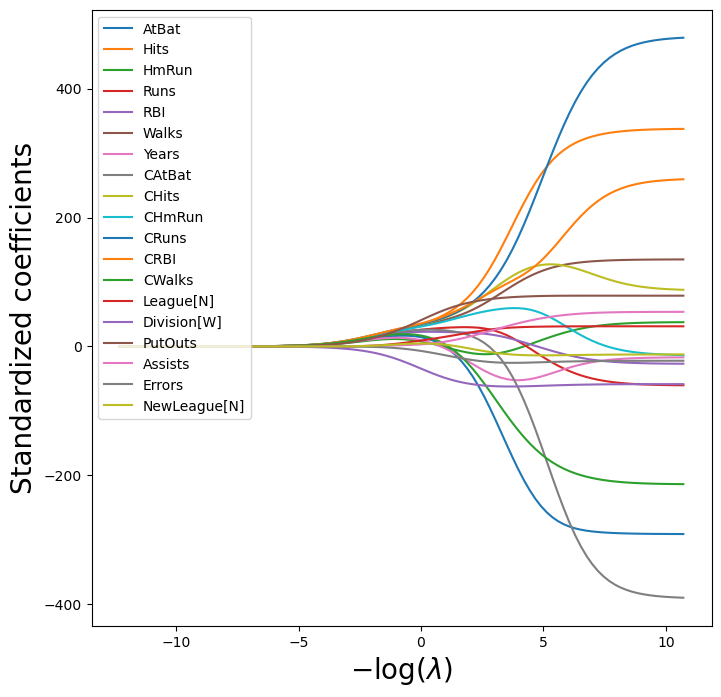

In [26]:
path_fig, ax = subplots(figsize=(8,8))                   # Create a subplot with specified figure size
soln_path.plot(ax=ax, legend=False)                      # Plot the solution path on the specified axis
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)           # Set the x-axis label with font size
ax.set_ylabel('Standardized coefficients', fontsize=20)  # Set the y-axis label with font size
ax.legend(loc='upper left');                             # Add a legend to the upper left of the plot

(We have used `latex` formatting in the horizontal label, in order to format the Greek $\lambda$ appropriately.) 
We expect the coefficient estimates to be much smaller, in terms of
$\ell_2$ norm, when a large value of $\lambda$ is used, as compared to
when a small value of $\lambda$ is used. (Recall that the  $\ell_2$ norm is the square root of the sum of squared coefficient values.) We display  the coefficients at the $40$th step,
where $\lambda$ is 25.535.

In [27]:
beta_hat = soln_path.loc[soln_path.index[39]]  # Extract the coefficients for the 40th value of -log(lambda)
lambdas[39], beta_hat                          # Display the lambda value and the corresponding coefficients

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

Let’s compute the $\ell_2$ norm of the standardized coefficients.

In [28]:
np.linalg.norm(beta_hat)  # Compute the Euclidean norm (L2 norm) of the coefficients vector beta_hat

24.17061720144378

In contrast, here is the $\ell_2$ norm when $\lambda$ is 2.44e-01.
Note the much larger $\ell_2$ norm of the
coefficients associated with this smaller value of $\lambda$.

In [29]:
beta_hat = soln_path.loc[soln_path.index[59]]  # Extract the coefficients vector for the 60th value of lambda from soln_path
lambdas[59], np.linalg.norm(beta_hat)          # Output the 60th lambda value and the Euclidean norm (L2 norm) of beta_hat

(0.24374766133488554, 160.42371017725793)

Above we normalized `X` upfront, and fit the ridge model using `Xs`.
The `Pipeline()`  object
in `sklearn` provides a clear way to separate feature
normalization from the fitting of the ridge model itself.

In [30]:
# Create an ElasticNet model with alpha set to the 60th lambda and l1_ratio set to 0 (ridge regression)
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0) 

# Initialize a StandardScaler to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler(with_mean=True, with_std=True)

# Create a pipeline with standardization and ridge regression
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])  

# Fit the pipeline on the data X and target Y
pipe.fit(X, Y) 

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [31]:
np.linalg.norm(ridge.coef_)  # Compute the L2 norm (Euclidean norm) of the ridge regression coefficients

160.42371017725927

 Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before. 
### Estimating Test Error of Ridge Regression
Choosing an *a priori* value of $\lambda$ for ridge regression is
difficult if not impossible. We will want to use the validation method
or cross-validation to select the tuning parameter. The reader may not
be surprised that the  `Pipeline()` approach can be used in
`skm.cross_validate()` with either a validation method
(i.e. `validation`) or $k$-fold cross-validation.

We fix the random state of the splitter
so that the results obtained will be reproducible.

In [32]:
validation = skm.ShuffleSplit(n_splits=1,      # Define a cross-validation strategy with 1 split
                              test_size=0.5,   # Use 50% of data for testing
                              random_state=0)  # Set random seed for reproducibility

ridge.alpha = 0.01  # Set the alpha parameter for the ridge regression model

results = skm.cross_validate(ridge,  # Perform cross-validation with the ridge regression model
                             X,      # Input features
                             Y,      # Target values
                             scoring='neg_mean_squared_error',  # Use negative mean squared error as the scoring metric
                             cv=validation)                     # Use the defined cross-validation strategy

-results['test_score']  # Output the negative mean squared error for the test set

array([134214.00419204])

The test MSE is 1.342e+05.  Note
that if we had instead simply fit a model with just an intercept, we
would have predicted each test observation using the mean of the
training observations. We can get the same result by fitting a ridge regression model
with a *very* large value of $\lambda$. Note that `1e10`
means $10^{10}$.

In [33]:
ridge.alpha = 1e10  # Set the alpha parameter to a very large value

results = skm.cross_validate(ridge,  # Perform cross-validation with the ridge regression model
                             X,      # Input features
                             Y,      # Target values
                             scoring='neg_mean_squared_error',  # Use negative mean squared error as the scoring metric
                             cv=validation)                     # Use the defined cross-validation strategy

-results['test_score']  # Output the negative mean squared error for the test set

array([231788.32155285])

Obviously choosing $\lambda=0.01$ is arbitrary,  so we will  use cross-validation or the validation-set
approach to choose the tuning parameter $\lambda$.
The object `GridSearchCV()`  allows exhaustive
grid search to choose such a parameter.

We first use the validation set method
to choose $\lambda$.

In [34]:
param_grid = {'ridge__alpha': lambdas}  # Define the parameter grid for alpha values

grid = skm.GridSearchCV(pipe,                              # Initialize GridSearchCV with the pipeline
                        param_grid,                        # Parameter grid to search
                        cv=validation,                     # Use the defined cross-validation strategy
                        scoring='neg_mean_squared_error')  # Use negative mean squared error as the scoring metric

grid.fit(X, Y)                      # Fit the GridSearchCV to the data
grid.best_params_['ridge__alpha']   # Output the best alpha value found
grid.best_estimator_                # Output the best estimator found during the grid search

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

Alternatively, we can use 5-fold cross-validation.

In [35]:
grid = skm.GridSearchCV(pipe,        # Initialize GridSearchCV with the pipeline
                        param_grid,  # Parameter grid to search
                        cv=kfold,    # Use k-fold cross-validation strategy
                        scoring='neg_mean_squared_error')  # Use negative mean squared error as the scoring metric

grid.fit(X, Y)                     # Fit the GridSearchCV to the data
grid.best_params_['ridge__alpha']  # Output the best alpha value found
grid.best_estimator_               # Output the best estimator found during the grid search

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Recall we set up the `kfold` object for 5-fold cross-validation on page~\pageref{line:choos-among-models}. We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

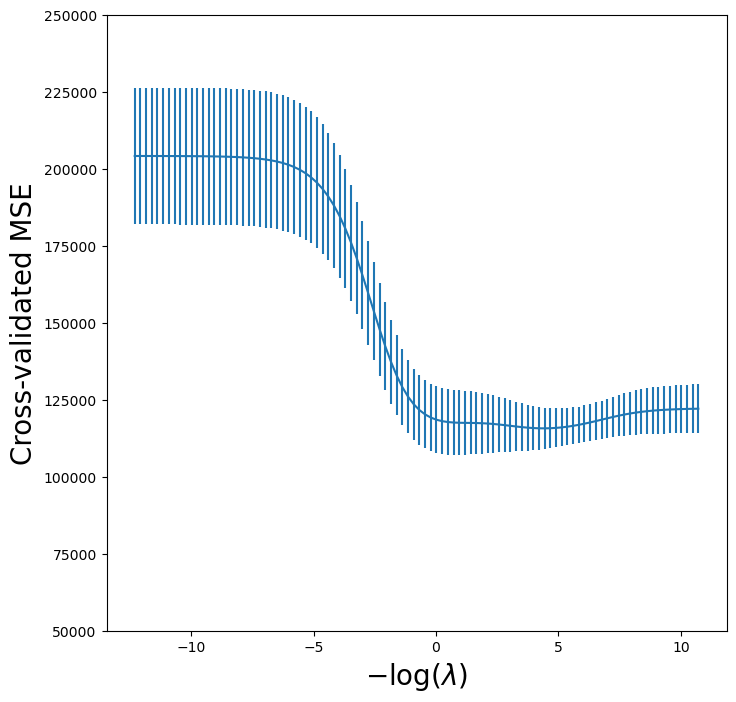

In [36]:
ridge_fig, ax = subplots(figsize=(8,8))  # Create a new figure and axes with specified size

ax.errorbar(-np.log(lambdas),                                      # X-axis values: negative log of lambdas
            -grid.cv_results_['mean_test_score'],                  # Y-axis values: mean test score (MSE) with a negative sign
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))  # Error bars: standard deviation divided by the square root of K

ax.set_ylim([50000,250000])                         # Set the y-axis limits
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)      # Set the x-axis label with font size 20
ax.set_ylabel('Cross-validated MSE', fontsize=20);  # Set the y-axis label with font size 20

One can cross-validate different metrics to choose a parameter. The default
metric for `skl.ElasticNet()` is test $R^2$.
Let’s compare $R^2$ to MSE for cross-validation here.

In [37]:
grid_r2 = skm.GridSearchCV(pipe,       # Create a GridSearchCV instance for model tuning
                           param_grid, # Parameter grid to search
                           cv=kfold)   # Cross-validation strategy

grid_r2.fit(X, Y)  # Fit the GridSearchCV to the data

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Finally, let’s plot the results for cross-validated $R^2$.

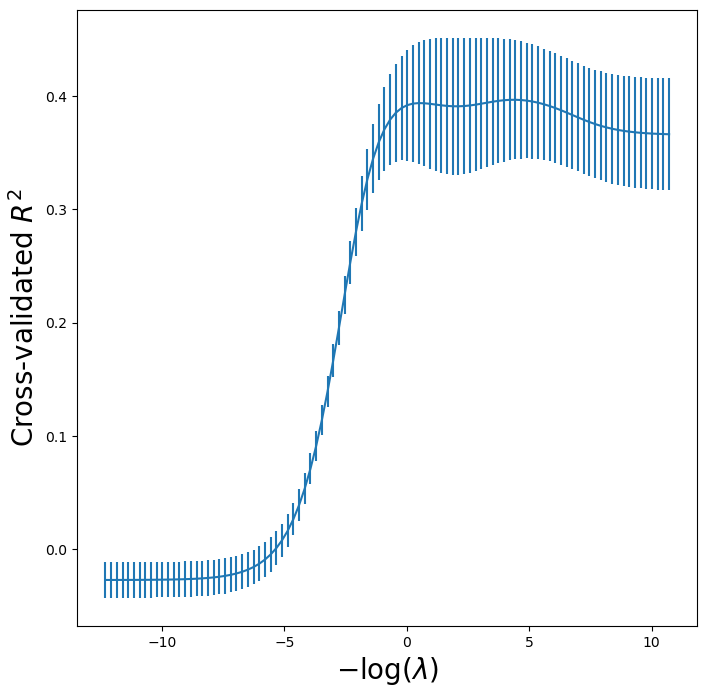

In [38]:
r2_fig, ax = subplots(figsize=(8,8))  # Create a new figure and axis for plotting

ax.errorbar(-np.log(lambdas),                                         # X-axis values: negative log of lambda
            grid_r2.cv_results_['mean_test_score'],                   # Y-axis values: mean cross-validated R^2 scores
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))  # Error bars: standard deviation of scores divided by the square root of K

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)        # Set the x-axis label with LaTeX formatting
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);  # Set the y-axis label with LaTeX formatting

### Fast Cross-Validation for Solution Paths
The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path*. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. Even with
identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [39]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,  # Initialize ElasticNetCV with the provided alpha values (lambdas) and l1_ratio=0
                           l1_ratio=0,      # Set l1_ratio to 0 for ridge regression (no L1 penalty)
                           cv=kfold)        # Specify the cross-validation strategy using kfold

pipeCV = Pipeline(steps=[('scaler', scaler),   # Create a pipeline with two steps: scaling and ElasticNetCV
                         ('ridge', ridgeCV)])  # Add the ElasticNetCV model as the second step in the pipeline

pipeCV.fit(X, Y)  # Fit the pipeline to the data, scaling X and then applying ElasticNetCV

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

Text(0, 0.5, 'Cross-validated MSE')

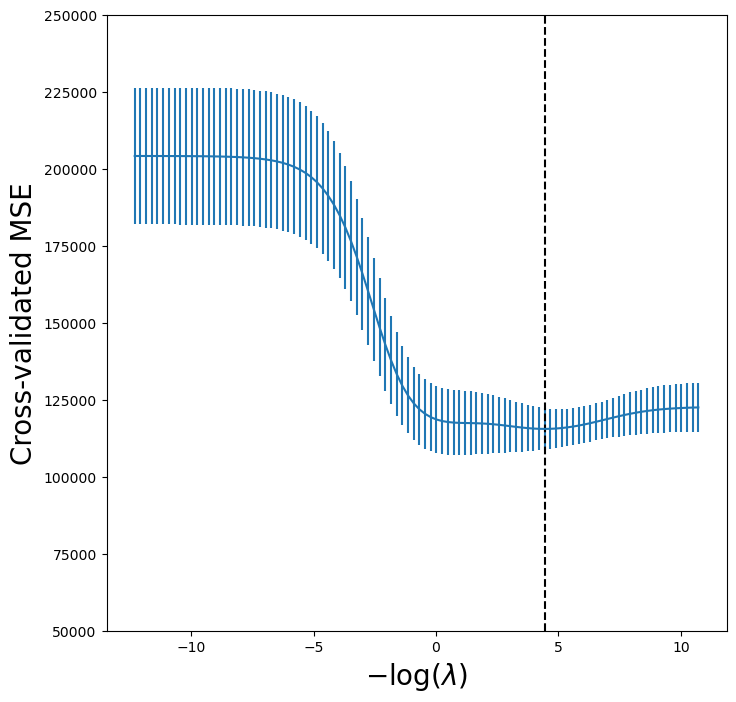

In [40]:
tuned_ridge = pipeCV.named_steps['ridge']  # Extract the ElasticNetCV model from the pipeline

ridgeCV_fig, ax = subplots(figsize=(8,8))  # Create a figure and axis for plotting

ax.errorbar(-np.log(lambdas),                                # X-axis: negative log of lambda values
            tuned_ridge.mse_path_.mean(1),                   # Y-axis: mean cross-validated MSE for each lambda
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))  # Error bars: standard deviation of MSE divided by sqrt(K)

ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')  # Add a vertical line at the best lambda (alpha) found by ElasticNetCV

ax.set_ylim([50000,250000])  # Set the y-axis limits

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)     # Set the x-axis label
ax.set_ylabel('Cross-validated MSE', fontsize=20)  # Set the y-axis label

We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.19e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [41]:
np.min(tuned_ridge.mse_path_.mean(1))  # Compute the minimum cross-validated MSE from the mean MSE path

115526.7063098792

This represents a further improvement over the test MSE that we got
using $\lambda=4$.  Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [42]:
tuned_ridge.coef_  # Retrieve the coefficients of the ElasticNet model with tuned alpha

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

As expected, none of the coefficients are zero—ridge regression does
not perform variable selection!

### Evaluating Test Error of Cross-Validated Ridge
Choosing $\lambda$ using cross-validation provides a single regression
estimator, similar to fitting a linear regression model as we saw in
Chapter~\ref{Ch3:linreg}. It is therefore reasonable to estimate what its test error
is. We run into a problem here in that cross-validation will have
*touched* all of its data in choosing $\lambda$, hence we have no
further data to estimate test error. A compromise is to do an initial
split of the data into two disjoint sets: a training set and a test set.
We then fit a cross-validation
tuned ridge regression on the training set, and evaluate its performance on the test set.
We might call this cross-validation nested
within the validation set approach. A priori there is no reason to use
half of the data for each of the two sets in validation. Below, we use
75% for training and 25% for test, with the estimator being ridge
regression tuned using 5-fold cross-validation.  This can be achieved
in code as follows:

In [43]:
outer_valid = skm.ShuffleSplit(n_splits=1,      # Number of splits in outer cross-validation
                               test_size=0.25,  # Proportion of the dataset to include in the test split
                               random_state=1)  # Seed for the random number generator

inner_cv = skm.KFold(n_splits=5,      # Number of splits in inner cross-validation
                     shuffle=True,    # Whether to shuffle the data before splitting
                     random_state=2)  # Seed for the random number generator

ridgeCV = skl.ElasticNetCV(alphas=lambdas,  # Alpha values to test
                           l1_ratio=0,      # L1 ratio for ElasticNet (0 means Ridge regression)
                           cv=inner_cv)     # Cross-validation strategy for ElasticNetCV

pipeCV = Pipeline(steps=[('scaler', scaler),   # Step for scaling the data
                         ('ridge', ridgeCV)])  # Step for ElasticNetCV

In [44]:
results = skm.cross_validate(pipeCV,          # Cross-validate the pipeline with ElasticNetCV
                             X,               # Feature matrix
                             Y,               # Target vector
                             cv=outer_valid,  # Outer cross-validation strategy
                             scoring='neg_mean_squared_error')  # Metric to evaluate performance

-results['test_score']  # Negative mean squared error of the test set (convert to positive)

array([132393.84003227])

### The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [45]:
lassoCV = skl.ElasticNetCV(n_alphas=100,  # Create ElasticNetCV model with 100 alpha values
                           l1_ratio=1,    # Set l1_ratio to 1 for Lasso (pure L1 regularization)
                           cv=kfold)      # Use k-fold cross-validation

pipeCV = Pipeline(steps=[('scaler', scaler),   # Define the pipeline with scaling and Lasso regression
                         ('lasso', lassoCV)])  # Add the LassoCV step to the pipeline

pipeCV.fit(X, Y)  # Fit the pipeline to the data

tuned_lasso = pipeCV.named_steps['lasso']  # Access the fitted LassoCV model from the pipeline
tuned_lasso.alpha_                         # Get the best alpha value found by the LassoCV model

3.1472370031649883

In [46]:
lambdas, soln_array = skl.Lasso.path(Xs,               # Compute the path of Lasso solutions
                                    Y,                 # Target variable
                                    l1_ratio=1,        # Set l1_ratio to 1 for Lasso (pure L1 regularization)
                                    n_alphas=100)[:2]  # Use 100 alpha values and get lambdas and solution array

soln_path = pd.DataFrame(soln_array.T,            # Create a DataFrame from the transposed solution array
                         columns=D.columns,       # Set column names from DataFrame D
                         index=-np.log(lambdas))  # Set index to negative log of lambdas

We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

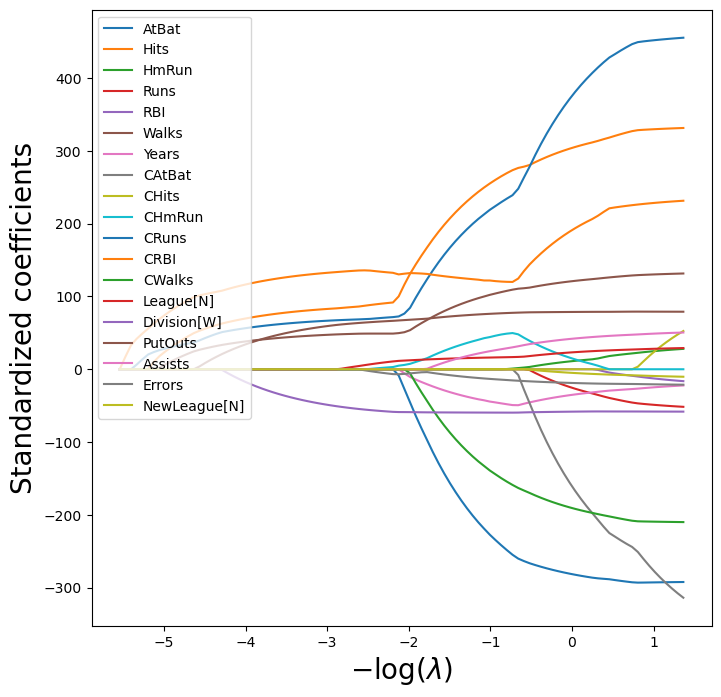

In [47]:
path_fig, ax = subplots(figsize=(8,8))                    # Create a figure and axis with a size of 8x8 inches
soln_path.plot(ax=ax, legend=False)                       # Plot the solution path on the axis, without a legend
ax.legend(loc='upper left')                               # Add a legend to the upper left of the plot
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)            # Set the x-axis label with LaTeX formatting and font size 20
ax.set_ylabel('Standardized coefficients', fontsize=20);  # Set the y-axis label with font size 20

The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression (page~\pageref{page:MSECVRidge}) with $\lambda$ chosen by cross-validation.

In [48]:
np.min(tuned_lasso.mse_path_.mean(1))  # Compute the minimum mean squared error from the lasso model's MSE path

114690.73118253653

Let’s again produce a plot of the cross-validation error.


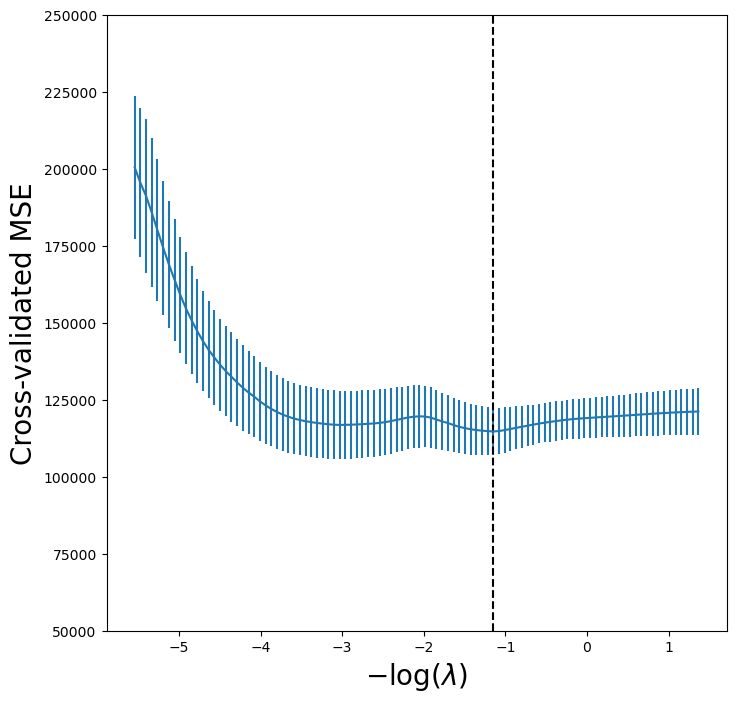

In [49]:
lassoCV_fig, ax = subplots(figsize=(8,8))  # Create a new figure with specified size

ax.errorbar(-np.log(tuned_lasso.alphas_),                    # Plot -log(lambda) on x-axis
            tuned_lasso.mse_path_.mean(1),                   # Plot mean cross-validated MSE on y-axis
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))  # Plot error bars for the MSE with standard deviation

ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')  # Add a vertical line for the optimal lambda
ax.set_ylim([50000,250000])                              # Set y-axis limits
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)           # Set x-axis label
ax.set_ylabel('Cross-validated MSE', fontsize=20);       # Set y-axis label

However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are sparse. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [50]:
tuned_lasso.coef_  # Retrieve the coefficients of the fitted Lasso model

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. We leave
this as an exercise.

## PCR and PLS Regression

### Principal Components Regression

Principal components regression (PCR) can be performed using
`PCA()`  from the `sklearn.decomposition`
module. We now apply PCR to the  `Hitters`  data, in order to
predict `Salary`. Again, ensure that the missing values have
been removed from the data, as described in Section~\ref{Ch6-varselect-lab:lab-1-subset-selection-methods}.

We use `LinearRegression()`  to fit the regression model
here. Note that it fits an intercept by default, unlike
the `OLS()` function seen earlier in Section~\ref{Ch6-varselect-lab:lab-1-subset-selection-methods}.

In [51]:
pca = PCA(n_components=2)        # Initialize PCA with 2 components
linreg = skl.LinearRegression()  # Initialize Linear Regression model

pipe = Pipeline([('pca', pca),         # Create a pipeline with PCA and Linear Regression
                 ('linreg', linreg)])  # Assign PCA and Linear Regression to the pipeline

pipe.fit(X, Y)                    # Fit the pipeline to the data
pipe.named_steps['linreg'].coef_  # Retrieve the coefficients of the Linear Regression model from the pipeline

array([0.09846131, 0.4758765 ])

When performing PCA, the results vary depending
on whether the data has been *standardized* or not.
As in the earlier examples, this can be accomplished
by including an additional step in the pipeline.

In [52]:
pipe = Pipeline([('scaler', scaler),   # Add StandardScaler to the pipeline
                 ('pca', pca),         # Add PCA to the pipeline
                 ('linreg', linreg)])  # Add Linear Regression to the pipeline

pipe.fit(X, Y)                    # Fit the pipeline to the data
pipe.named_steps['linreg'].coef_  # Retrieve the coefficients of the Linear Regression model from the pipeline

array([106.36859204, -21.60350456])

We can of course use CV to choose the number of components, by
using `skm.GridSearchCV`, in this
case fixing the parameters to vary the
`n_components`.

In [53]:
param_grid = {'pca__n_components': range(1, 20)}  # Define the grid of hyperparameters to search for PCA components

grid = skm.GridSearchCV(pipe,        # Initialize GridSearchCV with the pipeline
                        param_grid,  # Specify the parameter grid to search
                        cv=kfold,    # Use k-fold cross-validation
                        scoring='neg_mean_squared_error')  # Evaluate model performance using negative mean squared error

grid.fit(X, Y)  # Fit GridSearchCV to the data

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

Let’s plot the results as we have for other methods.

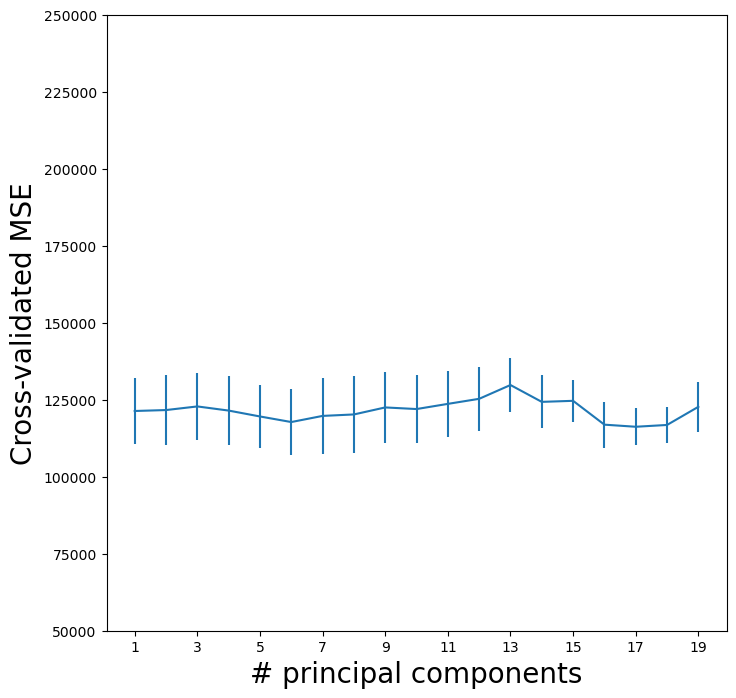

In [54]:
pcr_fig, ax = subplots(figsize=(8,8))     # Create a new figure and axis for the plot
n_comp = param_grid['pca__n_components']  # Get the number of principal components from the parameter grid

ax.errorbar(n_comp,                                           # Plot number of components on the x-axis
            -grid.cv_results_['mean_test_score'],             # Plot mean cross-validated MSE (negated)
            grid.cv_results_['std_test_score'] / np.sqrt(K))  # Plot the standard error of the MSE

ax.set_ylabel('Cross-validated MSE', fontsize=20)     # Set y-axis label
ax.set_xlabel('# principal components', fontsize=20)  # Set x-axis label
ax.set_xticks(n_comp[::2])    # Set x-ticks to show every second value of number of components
ax.set_ylim([50000,250000]);  # Set y-axis limits

We see that the smallest cross-validation error occurs when
17
components are used. However, from the plot we also see that the
cross-validation error is roughly the same when only one component is
included in the model. This suggests that a model that uses just a
small number of components might suffice.

The CV score is provided for each possible number of components from
1 to 19 inclusive. The `PCA()` method complains
if we try to fit an intercept only with `n_components=0`
so we also compute the MSE for just the null model with
these splits.

In [55]:
Xn = np.zeros((X.shape[0], 1))  # Create a new feature matrix with all zeros (no features)

cv_null = skm.cross_validate(linreg,    # Perform cross-validation on the linear regression model
                             Xn,        # Use the zero feature matrix
                             Y,         # Target variable
                             cv=kfold,  # Cross-validation strategy
                             scoring='neg_mean_squared_error')  # Scoring metric

-cv_null['test_score'].mean()   # Compute the mean negative mean squared error and negate it to get the MSE

204139.30692994667

The `explained_variance_ratio_`
attribute of our `PCA` object provides the *percentage of variance explained* in the predictors and in the response using
different numbers of components. This concept is discussed in greater
detail in Section~\ref{Ch10:sec:pca}.

In [56]:
pipe.named_steps['pca'].explained_variance_ratio_  # Get the explained variance ratio of each principal component

array([0.3831424 , 0.21841076])

Briefly, we can think of
this as the amount of information about the predictors
that is captured using $M$ principal components. For example, setting
$M=1$ only captures 38.31% of the variance, while $M=2$ captures an additional 21.84%, for a total of 60.15% of the variance.
By  $M=6$ it increases to
88.63%. Beyond this the increments continue to diminish, until we use all $M=p=19$ components, which captures all  100% of the variance.

 

### Partial Least Squares
Partial least squares (PLS) is implemented in the
`PLSRegression()`  function.

 

In [57]:
pls = PLSRegression(n_components=2,  # Initialize PLSRegression with 2 components
                    scale=True)      # Scale the data before applying PLS

pls.fit(X, Y)   # Fit the PLS model to the data

PLSRegression()

As was the case in PCR, we will want to
use CV to choose the number of components.

In [58]:
param_grid = {'n_components': range(1, 20)}  # Define the parameter grid for the number of components

grid = skm.GridSearchCV(pls,         # Initialize GridSearchCV with PLS model
                        param_grid,  # Set the parameter grid
                        cv=kfold,    # Use k-fold cross-validation
                        scoring='neg_mean_squared_error')  # Evaluate using negative mean squared error

grid.fit(X, Y)  # Fit the GridSearchCV object to the data

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

As for our other methods, we plot the MSE.

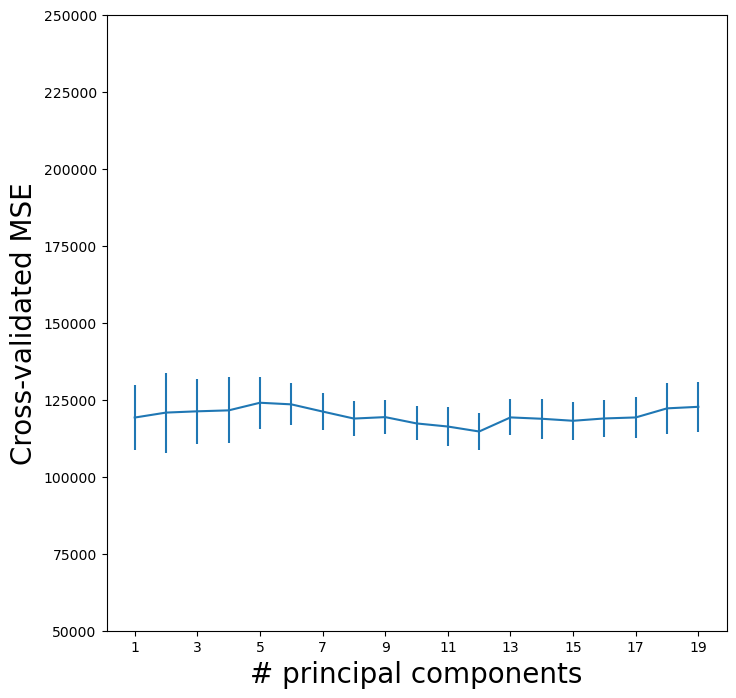

In [59]:
pls_fig, ax = subplots(figsize=(8,8))  # Create a figure and axes for plotting
n_comp = param_grid['n_components']    # Get the number of components from the parameter grid

ax.errorbar(n_comp,                                           # X-axis: number of principal components
            -grid.cv_results_['mean_test_score'],             # Y-axis: mean cross-validated MSE (negative)
            grid.cv_results_['std_test_score'] / np.sqrt(K))  # Error bars: standard deviation of test scores

ax.set_ylabel('Cross-validated MSE', fontsize=20)     # Label for the Y-axis
ax.set_xlabel('# principal components', fontsize=20)  # Label for the X-axis
ax.set_xticks(n_comp[::2])    # Set X-axis ticks to every other number of components
ax.set_ylim([50000,250000]);  # Set the Y-axis limits

CV error is minimized at 12,
though there is little noticable difference between this point and a much lower number like 2 or 3 components.

